In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plot
from image_utils import label_images, plot_images, count_samples

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Model, Sequential, models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

np.random.seed(6)

Using TensorFlow backend.


In [3]:
# # verify if tensorflow is running with GPU
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# # check if keras is using GPU
print(K.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0']


## Define data, sample size, and image parameters

In [37]:
# define datasets
train_data_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train/"
test_data_dir = "/kaggle/input/intel-image-classification/seg_test/seg_test/"
pred_data_dir = "/kaggle/input/intel-image-classification/seg_pred/"
 
# define datasets and sample size
num_train_samples = count_samples(train_data_dir)
num_test_samples = count_samples(test_data_dir)
num_pred_samples = count_samples(pred_data_dir)

# define image dimensions
img_width, img_height = 150, 150
img_target_size = (img_width, img_height)

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

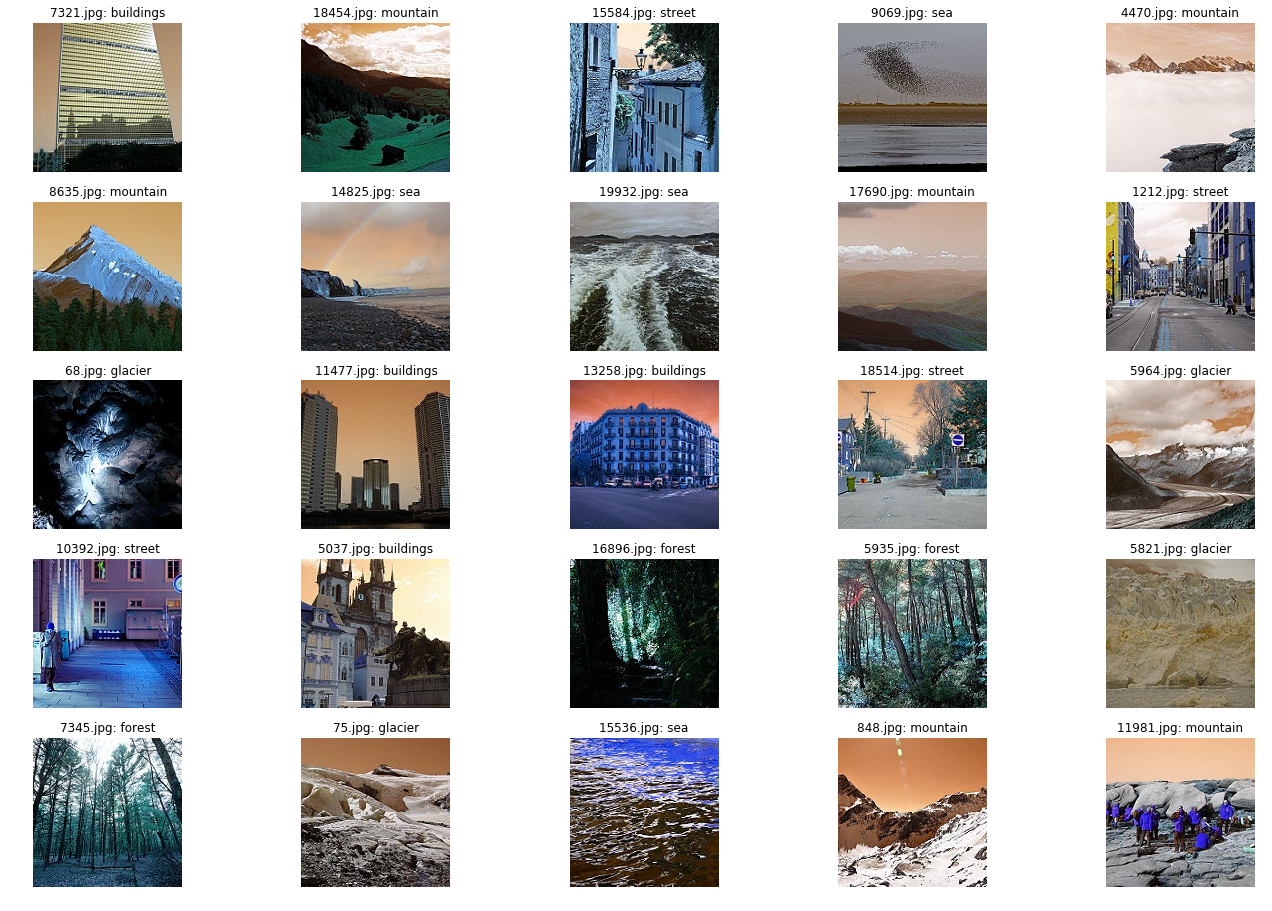

In [5]:
training_imgs, labeled_training_imgs = label_images(train_data_dir, '.jpg')
plot_images(training_imgs, labeled_training_imgs)

## Define hyperparameters and data generators

In [39]:
# define model hyperparameters
epochs = 10
batch_size = 64
neurons_per_layer = [2048, 1024, 512]
dropout = 0.5
n_classes = 6
patience = 3

# specify image augmentation
img_augmentation = ImageDataGenerator(preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True)

# prepare train/test data generators
train_data = img_augmentation.flow_from_directory(
    train_data_dir,
    target_size = img_target_size,
    batch_size = batch_size,
    class_mode = 'categorical')

test_data = img_augmentation.flow_from_directory(
    test_data_dir,
    target_size = img_target_size,
    batch_size = batch_size,
    class_mode = 'categorical')

pred_data = img_augmentation.flow_from_directory(
    pred_data_dir,
    target_size = img_target_size,
    batch_size = batch_size,
    class_mode = None,
    shuffle = False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 1 classes.


## Create and train model

In [20]:
# specify base model and freeze weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# create model function
def create_model(base_model, dropout, neurons_per_layer, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = layers.Flatten()(x)
    
    for num_neurons in neurons_per_layer:
        x = layers.Dense(num_neurons, activation='relu')(x) 
    
    x = layers.Dropout(dropout)(x)

    classifications = layers.Dense(num_classes, activation='softmax')(x) 
    model = Model(inputs=base_model.input, outputs=classifications)
    
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['acc'])

    return model

# instantiate model
model = create_model(base_model, dropout=dropout, neurons_per_layer=neurons_per_layer, num_classes=n_classes)

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [21]:
callbacks = [EarlyStopping(monitor='val_acc', patience=patience),
             ModelCheckpoint(filepath='resnet_iic_kaggle.h5', monitor='val_acc', save_best_only=True)]

# train model
history = model.fit_generator(
    train_data,
    steps_per_epoch = num_train_samples // batch_size,
    validation_data = test_data,
    validation_steps = num_test_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    verbose = 1,
    use_multiprocessing = True)

Epoch 1/10
219/219 [==============================] - 159s 728ms/step - loss: 1.5161 - acc: 0.7559 - val_loss: 0.4445 - val_acc: 0.8488
Epoch 2/10
219/219 [==============================] - 123s 561ms/step - loss: 0.4560 - acc: 0.8472 - val_loss: 0.4135 - val_acc: 0.8563
Epoch 3/10
219/219 [==============================] - 124s 565ms/step - loss: 0.4051 - acc: 0.8634 - val_loss: 0.3858 - val_acc: 0.8635
Epoch 4/10
219/219 [==============================] - 138s 632ms/step - loss: 0.3741 - acc: 0.8728 - val_loss: 0.4215 - val_acc: 0.8539
Epoch 5/10
219/219 [==============================] - 137s 625ms/step - loss: 0.3639 - acc: 0.8741 - val_loss: 0.4792 - val_acc: 0.8522
Epoch 6/10
219/219 [==============================] - 136s 622ms/step - loss: 0.3525 - acc: 0.8839 - val_loss: 0.3678 - val_acc: 0.8662
Epoch 7/10
219/219 [==============================] - 136s 619ms/step - loss: 0.3389 - acc: 0.8845 - val_loss: 0.5020 - val_acc: 0.8546
Epoch 8/10
219/219 [============================

## Plot training vs val accuracy

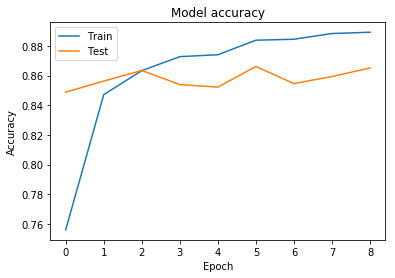

In [22]:
plot.plot(history.history['acc'])
plot.plot(history.history['val_acc'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

## Perform CV

In [23]:
test_score = model.evaluate_generator(test_data,
    steps = num_test_samples // batch_size,
    verbose=1,
    use_multiprocessing=True)

print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

46/46 [==============================] - 23s 496ms/step - loss: 0.4537 - acc: 0.8651
Test loss 0.4537, accuracy 86.51%


## Make predictions

In [40]:
pred_score = model.predict_generator(pred_data,
    steps = num_pred_samples // batch_size,
    verbose=1,
    use_multiprocessing=True)

print(pred_score)

114/114 [==============================] - 90s 793ms/step
[[3.0745890e-03 8.4918748e-09 5.2325686e-06 7.8165527e-08 1.3882404e-06
  9.9691868e-01]
 [2.8689888e-06 1.1151570e-06 2.4005422e-01 7.5990278e-01 3.0311478e-05
  8.6366117e-06]
 [1.0324474e-03 2.3990591e-16 1.3779997e-09 1.8733876e-13 1.5583503e-10
  9.9896753e-01]
 ...
 [1.6475458e-01 4.6217124e-04 7.3507042e-03 1.8248050e-03 9.1178752e-03
  8.1648988e-01]
 [7.9326266e-05 2.9303008e-05 5.4624915e-01 4.5221236e-01 1.1319274e-03
  2.9792704e-04]
 [1.9754802e-05 1.8371054e-16 6.6373795e-10 4.0033097e-13 1.5119908e-10
  9.9998021e-01]]
